# MTA Traffic Forecasting
#### Justin Morgan & Khyatee Desai
This notebook includes the data collection, storage, and cleaning process. The data is sourced from the following sources:<br>
1. Socrata API from NYC OpenData
<br>
2. [MTA turnstile data archive](http://web.mta.info/developers/turnstile.html), which all turnstile data from all NYC subway stations in comma delineated text files, segmented by week.


# Part 1: Data Collection

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import os
import requests
import urllib.request
import time
from timeit import default_timer as timer
import humanfriendly
from bs4 import BeautifulSoup
from datetime import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sodapy import Socrata
import geopandas as gpd
from shapely.geometry import shape

# import api token
from src import *

ModuleNotFoundError: No module named 'src.config'

## Use Socrata API from OpenData to download geospatial files

### Subway Station Shapefile

In [ ]:
# set client request for Socrata API
client = Socrata("data.cityofnewyork.us",app_token)

# make request using API endpoint
results = client.get("kk4q-3rt2")

# create GeoDataFrame out of request
station_gdf = gpd.GeoDataFrame(results)

In [32]:
# check info
station_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       473 non-null    object
 1   objectid  473 non-null    object
 2   name      473 non-null    object
 3   the_geom  473 non-null    object
 4   line      473 non-null    object
 5   notes     473 non-null    object
dtypes: object(6)
memory usage: 22.3+ KB


### Modified Zip Code Tabulation Areas

In [33]:
# set client for request Socrata API
client = Socrata("data.cityofnewyork.us", app_token)

# get shapefile from Soctrat API
results = client.get("pri4-ifjk")

# convert to GeoDataFrame
modzcta_gdf = gpd.GeoDataFrame(results)

In [34]:
modzcta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   modzcta   178 non-null    object
 1   label     178 non-null    object
 2   zcta      178 non-null    object
 3   pop_est   178 non-null    object
 4   the_geom  178 non-null    object
dtypes: object(5)
memory usage: 7.1+ KB


### Census Tract 2010 NYC Shapefile

In [35]:
# set client for request Socrata API
client = Socrata("data.cityofnewyork.us", app_token)

# get shapefile from Socrata API
results = client.get("i69b-3rdj", limit=20000)

# convert to geodataframe
ct_gdf = gpd.GeoDataFrame(results)

In [36]:
ct_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   the_geom     2165 non-null   object
 1   boro_name    2165 non-null   object
 2   boro_code    2165 non-null   object
 3   ctlabel      2165 non-null   object
 4   ct2010       2165 non-null   object
 5   boro_ct2010  2165 non-null   object
 6   cdeligibil   2164 non-null   object
 7   ntacode      2165 non-null   object
 8   ntaname      2165 non-null   object
 9   puma         2165 non-null   object
 10  shape_leng   2165 non-null   object
 11  shape_area   2165 non-null   object
dtypes: object(12)
memory usage: 203.1+ KB


### Set the Geometry and Coordinate Reference System (CRS)

Geometry column needs to be set. 

<u>Steps to complete:</u>

- use the `shapely` package to convert `the_geom` column from a geojson and return an independent geometry with coordinates.
- set the geometry column to the transformed `the_geom` column
- rename the `the_geom` column to `geometry`
- check dtypes to ensure `geometry` column is properly formatted

Since we are dealing soley with NYC, need to transform the GDF to New York State Plane EPSG 2263 CRS. This is typically used for projections of NYC, because it is the local coordinate system that best balances it's size and shape. 

<u>Steps to complete:</u>

- use the .to_crs() method to transform the GDF to EPSG 2263
- use .crs() method to verify it was correctly set

In [37]:
# function to set the geometry for shapefiles
def set_geom(gdf,geom_col,set_crs=4326, to_crs=2263):
    """
    function that converts geom column from a geojson to an
    independent geometry with coordinates
    sets the geometry column 
    sets CRS default is NAD 2263 for NYC
    renames to geomtry
    pass in df
    pass in column name as string
    """
    gdf[geom_col] = gdf[geom_col].apply(shape)
    gdf.set_geometry(geom_col, inplace=True)
    gdf.rename_geometry('geometry', inplace=True)
    gdf.set_crs(set_crs, inplace=True)
    gdf.to_crs(to_crs, inplace=True)
    return gdf.head()

In [38]:
set_geom(station_gdf, 'the_geom')

,url,objectid,name,geometry,line,notes
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (986725.002 205255.053),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (984196.500 201155.840),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (988724.216 216795.191),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (991184.246 187333.844),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (1013411.541 181467.289),3-4,"4-nights, 3-all other times"


In [39]:
set_geom(modzcta_gdf, 'the_geom')

,modzcta,label,zcta,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((987646.000 210360.000, 987522...."
1,10002,10002,10002,74993,"MULTIPOLYGON (((984942.000 199432.000, 985056...."
2,10003,10003,10003,54682,"MULTIPOLYGON (((987400.000 202660.000, 987366...."
3,10026,10026,10026,39363,"MULTIPOLYGON (((994768.000 232748.000, 995304...."
4,10004,10004,10004,3028,"MULTIPOLYGON (((981958.000 197118.000, 981652...."


In [40]:
set_geom(ct_gdf, 'the_geom')

,geometry,boro_name,boro_code,ctlabel,ct2010,boro_ct2010,cdeligibil,ntacode,ntaname,puma,shape_leng,shape_area
0,"MULTIPOLYGON (((962269.126 173705.500, 962288....",Staten Island,5,9,000900,5000900,E,SI22,West New Brighton-New Brighton-St. George,3903,7729.01679383,2497009.71359
1,"MULTIPOLYGON (((994133.507 214848.898, 994005....",Manhattan,1,98,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.19981063,1906016.35002
2,"MULTIPOLYGON (((993108.306 216013.131, 992982....",Manhattan,1,100,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.16873705,1860938.37721
3,"MULTIPOLYGON (((992216.539 216507.687, 992091....",Manhattan,1,102,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.80243866,1860992.70485
4,"MULTIPOLYGON (((991325.882 217001.689, 991199....",Manhattan,1,104,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.03636655,1864600.37503


### Export GeoDataFrames

In [41]:
# export shapefile for import into data analysis notebook
station_gdf.to_file('./shp/station_gdf.shp')
modzcta_gdf.to_file('./shp/modzcta_gdf.shp')
ct_gdf.to_file('./shp/ct_gdf.shp')

## Scrape MTA turnstile data from public website
The data is iteratively scraped from the webpage using BeautifulSoup, and the text files are currently stored locally within a "data" folder.
<br><br>
Future steps will involve storing this data within an S3 bucket in the AWS cloud for faster storage & retrieval.

In [93]:
url_root = r'http://web.mta.info/developers/' # set root url
starttime = timer() # start timer to time process

req = requests.get(url_root + 'turnstile.html') # send request
soup = BeautifulSoup(req.content, 'html.parser') # parse html and save to bs4 object
weekly_data = soup.find(class_='span-84 last') # find class_ where file links are locatedb

for one_a_tag in weekly_data.findAll('a')[:60]: #collecting past year (60 weeks)
    file = one_a_tag['href']
    datafile = url_root + file
    urllib.request.urlretrieve(datafile, './data/' + datafile[datafile.find('/turnstile_')+1:])
    time.sleep(1)
    print('Saving file turnstile ' + str(one_a_tag)[39:49])
    
endtime = timer()
print('Completed in ' + humanfriendly.format_timespan(endtime-starttime))

Saving file turnstile 200321.txt
Saving file turnstile 200314.txt
Saving file turnstile 200307.txt
Saving file turnstile 200229.txt
Saving file turnstile 200222.txt
Saving file turnstile 200215.txt
Saving file turnstile 200208.txt
Saving file turnstile 200201.txt
Completed in 24.94 seconds


Took __47 minutes and 17.79 seconds__ to download all files, also folder size is __12.05GB__

Maybe there is a better way to do this?

## Concatenate MTA Files
Concatenate each data file into a Pandas dataframe

In [94]:
# create main df using first file in the folder
for filename in os.listdir("./data/")[:1]:
    df = pd.read_csv("./data/"+filename)

# iterate over remaining files in the folder and concat them to main df
for filename in os.listdir("./data/")[1:]:
    df = pd.concat([df,pd.read_csv("./data/"+filename)])

In [95]:
df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/15/2020,00:00:00,REGULAR,7444885,2531033
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/15/2020,04:00:00,REGULAR,7444886,2531034
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/15/2020,08:00:00,REGULAR,7444899,2531046
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/15/2020,12:00:00,REGULAR,7444933,2531082
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/15/2020,16:00:00,REGULAR,7445032,2531110
...,...,...,...,...,...,...,...,...,...,...,...
213100,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/06/2020,04:00:00,REGULAR,5554,541
213101,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/06/2020,08:00:00,REGULAR,5554,541
213102,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/06/2020,12:00:00,REGULAR,5554,541
213103,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/06/2020,16:00:00,REGULAR,5554,541


# Part 2: Data Cleaning
The below cells entail cleaning, reformatting, and aggregating the data

### Field Descriptions <br>
http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

`C/A      = Control Area (A002)`<br>
`UNIT     = Remote Unit for a station (R051)`<br>
`SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)`<br>
`STATION  = Represents the station name the device is located at`<br>
`LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.`<br>
`DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   `<br>
`DATE     = Represents the date (MM-DD-YY)`<br>
`TIME     = Represents the time (hh:mm:ss) for a scheduled audit event`<br>
`DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)`<br>
        `1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.`<br>
        `2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.`<br>
`ENTRIES  = The comulative entry register value for a device`<br>
`EXIST    = The cumulative exit register value for a device`<br>


## Reformat Data Types
Convert strings to DateTime format

In [96]:
df.DATE = pd.to_datetime(df['DATE'])

### Change Time Column to Timestamp Object
*Commented out for now because probably not going to use timestamps, just focusing on date*

In [97]:
# df.TIME = pd.to_datetime(df['TIME'])
# df.TIME.apply(lambda x: dt.timestamp(x))

In [98]:
df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                    datetime64[ns]
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
dtype: object

### Inspect a specific station & date

In [99]:
df[(df.STATION == 'HALSEY ST') & (df.DATE.astype(str)=='2021-02-15')].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
36293,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,03:00:00,REGULAR,5897529,3008491
36294,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,07:00:00,REGULAR,5897606,3008499
36295,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,11:00:00,REGULAR,5897771,3008564
36296,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,15:00:00,REGULAR,5897864,3008636
36297,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,19:00:00,REGULAR,5897921,3008755


## Derive Daily Entries
Entries and Exits are currently listed cumulatively. The below process groups the dataframe by station, date, SCP, UNIT, and C/A on Max and Min, then subtracts the two to find the number of turnstile entries per day at each station.

*....not really sure what SCP, UNIT, and C/A are but i think they might indicate an individual tracker device at a station for each turnstile? idkidk*

In [100]:
# min gives us cumulative entries at the beginning of each day
df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].min()

ENTRIES
STATION   DATE       SCP      UNIT C/A            
1 AV      2020-01-25 00-00-00 R248 H007   15389653
                     00-00-01 R248 H007   61053043
                     00-03-00 R248 H007  370844140
                     00-03-01 R248 H007    2589982
                     00-03-02 R248 H007    6608876
...                                            ...
ZEREGA AV 2021-03-19 00-00-01 R326 R419     228104
                     00-03-00 R326 R419    1143437
                     00-03-01 R326 R419    1221708
                     00-05-00 R326 R419        232
                     00-05-01 R326 R419         39

[2078080 rows x 1 columns]

In [101]:
# max gives us cumulative entries at the end of each day
df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].max()

ENTRIES
STATION   DATE       SCP      UNIT C/A            
1 AV      2020-01-25 00-00-00 R248 H007   15391443
                     00-00-01 R248 H007   61055509
                     00-03-00 R248 H007  370844670
                     00-03-01 R248 H007    2590419
                     00-03-02 R248 H007    6609651
...                                            ...
ZEREGA AV 2021-03-19 00-00-01 R326 R419     228245
                     00-03-00 R326 R419    1143441
                     00-03-01 R326 R419    1222311
                     00-05-00 R326 R419        232
                     00-05-01 R326 R419         39

[2078080 rows x 1 columns]

In [102]:
# subtract min from max to get number of entries each day
grouped = df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].max()- df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].min()
grouped


ENTRIES
STATION   DATE       SCP      UNIT C/A          
1 AV      2020-01-25 00-00-00 R248 H007     1790
                     00-00-01 R248 H007     2466
                     00-03-00 R248 H007      530
                     00-03-01 R248 H007      437
                     00-03-02 R248 H007      775
...                                          ...
ZEREGA AV 2021-03-19 00-00-01 R326 R419      141
                     00-03-00 R326 R419        4
                     00-03-01 R326 R419      603
                     00-05-00 R326 R419        0
                     00-05-01 R326 R419        0

[2078080 rows x 1 columns]

### Sum Counts from all Devices

In [103]:
# sum up all of the devices at a station to get total daily entries
grouped_entries = grouped.groupby(['STATION', 'DATE']).sum()
grouped_entries

ENTRIES
STATION   DATE               
1 AV      2020-01-25     6000
          2020-01-26     4970
          2020-01-27    16013
          2020-01-28    17235
          2020-01-29    17554
...                       ...
ZEREGA AV 2021-03-15     1012
          2021-03-16      862
          2021-03-17      923
          2021-03-18      912
          2021-03-19      901

[158828 rows x 1 columns]

### Pivot Table

In [139]:
# pivot the dataframe so date is the index
entries_df = grouped_entries.pivot_table(index='DATE', columns='STATION')
entries_df.columns = entries_df.columns.droplevel(0) # drop unnecessary multindex level
entries_df.head()

STATION,1 AV,103 ST,103 ST-CORONA,104 ST,110 ST,111 ST,116 ST,116 ST-COLUMBIA,121 ST,125 ST,...,WHITEHALL S-FRY,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,WORLD TRADE CTR,WTC-CORTLANDT,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-25,6000.0,14248.0,12986.0,1158.0,5164.0,8085.0,16303.0,6295.0,1081.0,37303.0,...,3841.0,910.0,2232.0,2600.0,9569.0,3063.0,7034.0,6595.0,3998.0,1013.0
2020-01-26,4970.0,12145.0,10707.0,980.0,4342.0,6510.0,15009.0,5397.0,969.0,34775.0,...,4190.0,799.0,2003.0,2139.0,8478.0,2798.0,6515.0,6268.0,5403.0,848.0
2020-01-27,16013.0,26006.0,19709.0,4224.0,9872.0,15200.0,28503.0,13457.0,2136.0,70879.0,...,15904.0,1820.0,4187.0,6947.0,22474.0,6257.0,17226.0,11485.0,11084.0,2518.0
2020-01-28,17235.0,28136.0,20482.0,4545.0,10630.0,16052.0,30864.0,14029.0,2234.0,73699.0,...,16550.0,1934.0,4505.0,7467.0,23701.0,6530.0,18041.0,12312.0,11561.0,2697.0
2020-01-29,17554.0,28374.0,20533.0,4611.0,10780.0,16097.0,30889.0,13972.0,2242.0,74090.0,...,17078.0,2008.0,4584.0,7642.0,23736.0,6510.0,17851.0,12108.0,11728.0,2807.0


## Check for Nulls
Will impute all nulls in the next step (outliers)

In [140]:
# find stations containing null values
entries_df.columns[entries_df.isnull().sum().values>0]

Index(['116 ST-COLUMBIA', '157 ST', '191 ST', '207 ST', '215 ST',
       '3 AV-149 ST', '75 ST-ELDERTS', '85 ST-FOREST PK', 'B'WAY-LAFAYETTE',
       'BAY RIDGE-95 ST', 'CANARSIE-ROCKAW', 'E 149 ST', 'EASTN PKWY-MUSM',
       'JAMAICA VAN WK', 'MARBLE HILL-225', 'MORRIS PARK', 'ORCHARD BEACH',
       'SUTTER AV-RUTLD', 'TOMPKINSVILLE', 'WORLD TRADE CTR'],
      dtype='object', name='STATION')

## Impute Outliers
This process identities outliers (larger 3X the median,) converts them to null, then interpolates them using the surrounding data points.
*This method was used to identify outliers rather than mean and standard deviation, because they were heavily influenced by large outliers*
### Inspect Outlier in 14th St Station Data

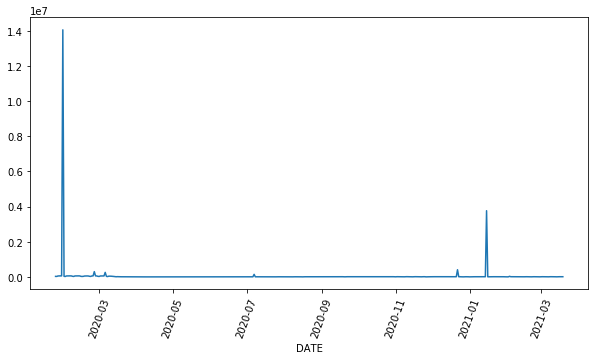

In [141]:
plt.figure(figsize=(10,5));
sns.lineplot(entries_df['14 ST'].index, entries_df['14 ST'].values);
plt.xticks(rotation=70);

In [142]:
# replace all outliers with null
for col in entries_df.columns:
    median = entries_df[col].median()
    std_3 = entries_df[col].std() 
    mean = entries_df[col].mean()
    entries_df[col] = np.where(entries_df[col] > median*2, np.nan, entries_df[col])


In [143]:
# inspect all nulls that were added due to outliers
entries_df.isnull().sum()

STATION
1 AV               36
103 ST             43
103 ST-CORONA      35
104 ST             34
110 ST             41
                   ..
WOODLAWN           35
WORLD TRADE CTR    57
WTC-CORTLANDT      50
YORK ST            50
ZEREGA AV          35
Length: 379, dtype: int64

### Interpolate to Fill Gaps

In [144]:
# replace null values with surrounding data points
for col in entries_df.columns:
    entries_df[col] = entries_df[col].interpolate(method='time',limit_direction='both')

In [145]:
# confirm nulls have been replaced
entries_df.isnull().sum().any()

False

### Inspect after outliers were imputed

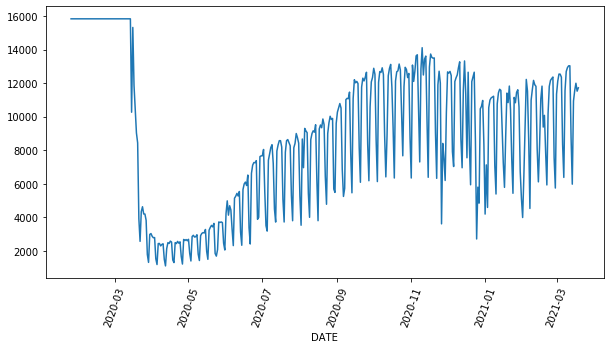

In [146]:
plt.figure(figsize=(10,5));
sns.lineplot(entries_df['14 ST'].index, entries_df['14 ST'].values);
plt.xticks(rotation=70);

### Create 'Total' Column

In [147]:
entries_df['TOTAL'] = entries_df.sum(axis=1)
entries_df

STATION,1 AV,103 ST,103 ST-CORONA,104 ST,110 ST,111 ST,116 ST,116 ST-COLUMBIA,121 ST,125 ST,...,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,WORLD TRADE CTR,WTC-CORTLANDT,YORK ST,ZEREGA AV,TOTAL
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-25,6000.0,12145.000000,12986.000000,1158.000000,5164.000000,8085.000000,15009.000000,1699.0,1081.0,34775.000000,...,910.0,2232.000000,2600.000000,9569.0,3063.000000,3983.0,2014.0,3998.000000,1013.000000,1.877042e+06
2020-01-26,4970.0,12145.000000,10707.000000,980.000000,4342.000000,6510.000000,15009.000000,1699.0,969.0,34775.000000,...,799.0,2003.000000,2139.000000,8478.0,2798.000000,3983.0,2014.0,3984.285714,848.000000,1.789382e+06
2020-01-27,5211.5,12312.285714,11175.166667,1169.666667,4356.857143,6533.479167,14979.428571,1699.0,1010.5,34550.428571,...,819.5,2000.428571,2271.333333,9072.5,2922.833333,3983.0,2014.0,3970.571429,889.833333,1.814949e+06
2020-01-28,5453.0,12479.571429,11643.333333,1359.333333,4371.714286,6556.958333,14949.857143,1699.0,1052.0,34325.857143,...,840.0,1997.857143,2403.666667,9667.0,3047.666667,3983.0,2014.0,3956.857143,931.666667,1.840517e+06
2020-01-29,5694.5,12646.857143,12111.500000,1549.000000,4386.571429,6580.437500,14920.285714,1699.0,1093.5,34101.285714,...,860.5,1995.285714,2536.000000,10261.5,3172.500000,3983.0,2014.0,3943.142857,973.500000,1.866085e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,5268.0,9454.000000,9604.000000,1807.000000,3424.000000,6846.000000,10372.000000,2273.0,980.0,22645.000000,...,767.0,1426.000000,2831.000000,8939.0,2626.000000,2408.0,1791.0,2245.000000,1012.000000,1.477816e+06
2021-03-16,5603.0,9833.000000,9215.000000,1870.000000,3857.000000,7587.000000,10726.000000,2402.0,933.0,23895.000000,...,795.0,1531.000000,2912.000000,8538.0,2753.000000,2489.0,1759.0,2356.000000,862.000000,1.541218e+06
2021-03-17,5615.0,9971.000000,9383.000000,1876.000000,3944.000000,7410.000000,11243.000000,2395.0,1026.0,23802.000000,...,803.0,1565.000000,2984.000000,9219.0,2811.000000,2472.0,1808.0,2494.000000,923.000000,1.579899e+06


### Pickle Cleaned Data

In [148]:
entries_df.to_pickle("./pickled/cleaned_data")